In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import seaborn as sns


In [3]:
IMAGE_SIZE = 224
CHANNELS = 3
BATCH_SIZE = 32

In [5]:
original_train_dir = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'
orig_train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
)

orig_train_data = orig_train_datagen.flow_from_directory(
    original_train_dir,  # Point to the new writable directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 7395 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


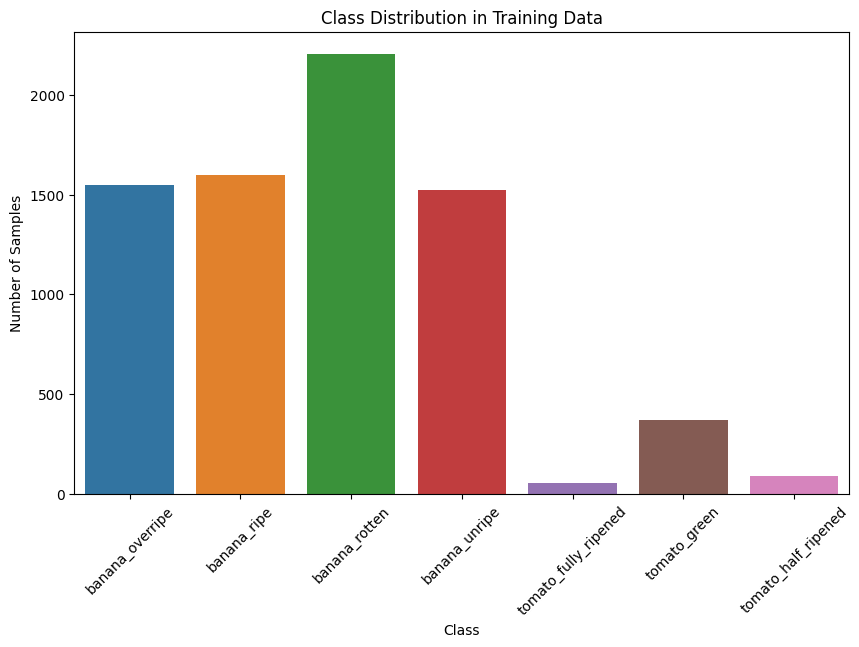

In [6]:
# Get class labels and their corresponding indices
class_labels = list(orig_train_data.class_indices.keys())

# Count the number of samples per class
class_counts = np.bincount(orig_train_data.classes)

# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels, y=class_counts)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

In [7]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Define the base directory where your training data is located
base_dir = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'

# Specify the classes you want to augment
classes_to_augment = ['tomato_half_ripened', 'tomato_green', 'tomato_fully_ripened']

# Specify the number of augmented images to generate per class
num_augmented_images = 500

# Define the base directory for saving augmented data in the writable /kaggle/working/ directory
augmented_base_dir = '/kaggle/working/augmented_data'
os.makedirs(augmented_base_dir, exist_ok=True)

# Initialize the ImageDataGenerator for augmentation
datagen_augment = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
for class_name in classes_to_augment:
    original_class_dir = os.path.join(base_dir, class_name)
    augmented_class_dir = os.path.join(augmented_base_dir, class_name)  # Save in /kaggle/working/augmented_data/class_name
    os.makedirs(augmented_class_dir, exist_ok=True)

    image_files = [f for f in os.listdir(original_class_dir) if os.path.isfile(os.path.join(original_class_dir, f))]
    print(f"Found {len(image_files)} images in class: {class_name}")

    # Create a generator for the current class, saving to the augmented directory in /kaggle/working/
    image_generator = datagen_augment.flow_from_directory(
        base_dir,
        classes=[class_name],
        target_size=(224, 224),
        batch_size=1,
        shuffle=True,
        save_to_dir=augmented_class_dir,  
        save_prefix='augmented',
        save_format='jpg'
    )

    # Generate the specified number of augmented images
    num_generated = 0
    for _ in range(num_augmented_images):
        next(image_generator)
        num_generated += 1
    print(f"Generated {num_generated} augmented images for class: {class_name} in {augmented_class_dir}")

print("Augmentation process complete! Augmented images are saved in /kaggle/working/augmented_data/")

Found 90 images in class: tomato_half_ripened
Found 90 images belonging to 1 classes.
Generated 500 augmented images for class: tomato_half_ripened in /kaggle/working/augmented_data/tomato_half_ripened
Found 371 images in class: tomato_green
Found 371 images belonging to 1 classes.
Generated 500 augmented images for class: tomato_green in /kaggle/working/augmented_data/tomato_green
Found 55 images in class: tomato_fully_ripened
Found 55 images belonging to 1 classes.
Generated 500 augmented images for class: tomato_fully_ripened in /kaggle/working/augmented_data/tomato_fully_ripened
Augmentation process complete! Augmented images are saved in /kaggle/working/augmented_data/


In [8]:
import shutil

# Define the source and destination directories
original_train_dir = '/kaggle/input/fine-grained-fruit-quality-assessment/train/train'
writable_train_dir = '/kaggle/working/writable_train_data'
augmented_base_dir = '/kaggle/working/augmented_data'

# Create the writable train directory and copy the original data
if os.path.exists(writable_train_dir):
    shutil.rmtree(writable_train_dir)  # Remove if it exists from a previous run
shutil.copytree(original_train_dir, writable_train_dir)
print(f"Original training data copied to {writable_train_dir}")

# Move augmented images to the corresponding class folders in the writable directory
for class_name in classes_to_augment:
    src_dir = os.path.join(augmented_base_dir, class_name)
    dest_dir = os.path.join(writable_train_dir, class_name)
    for filename in os.listdir(src_dir):
        if filename.startswith('augmented'):
            src_file = os.path.join(src_dir, filename)
            dest_file = os.path.join(dest_dir, filename)
            shutil.move(src_file, dest_file)
    print(f"Moved augmented images for {class_name} to {dest_dir}")


print("ImageDataGenerators are now set up to use the training data with augmented images.")

Original training data copied to /kaggle/working/writable_train_data
Moved augmented images for tomato_half_ripened to /kaggle/working/writable_train_data/tomato_half_ripened
Moved augmented images for tomato_green to /kaggle/working/writable_train_data/tomato_green
Moved augmented images for tomato_fully_ripened to /kaggle/working/writable_train_data/tomato_fully_ripened
ImageDataGenerators are now set up to use the training data with augmented images.


In [9]:

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_data = train_datagen.flow_from_directory(
    writable_train_dir,  # Point to the new writable directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

val_data = train_datagen.flow_from_directory(
    writable_train_dir,  # Point to the new writable directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 7117 images belonging to 7 classes.
Found 1778 images belonging to 7 classes.


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


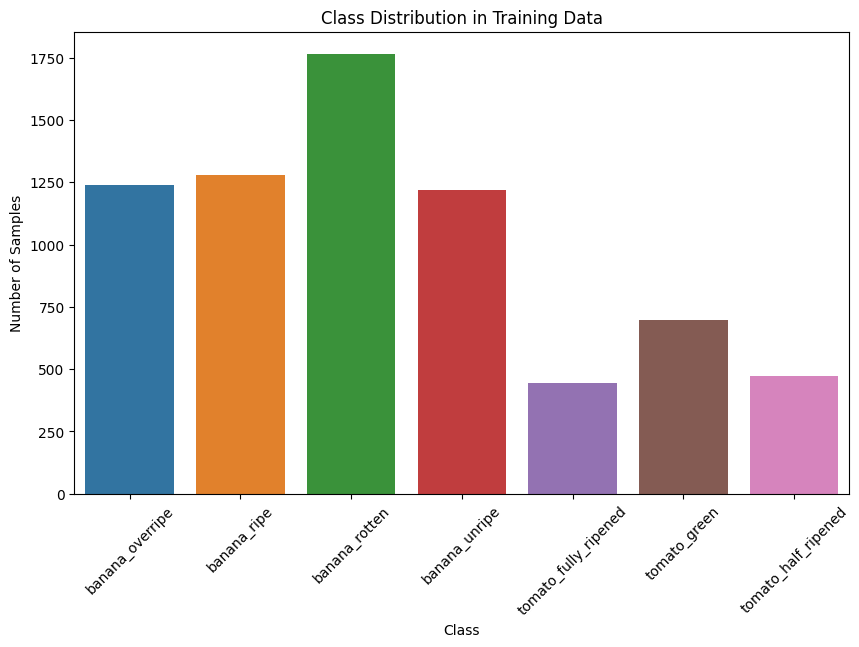

In [10]:
# Get class labels and their corresponding indices
class_labels = list(train_data.class_indices.keys())

# Count the number of samples per class
class_counts = np.bincount(train_data.classes)

# Plot the class distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=class_labels, y=class_counts)
plt.title('Class Distribution in Training Data')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.show()

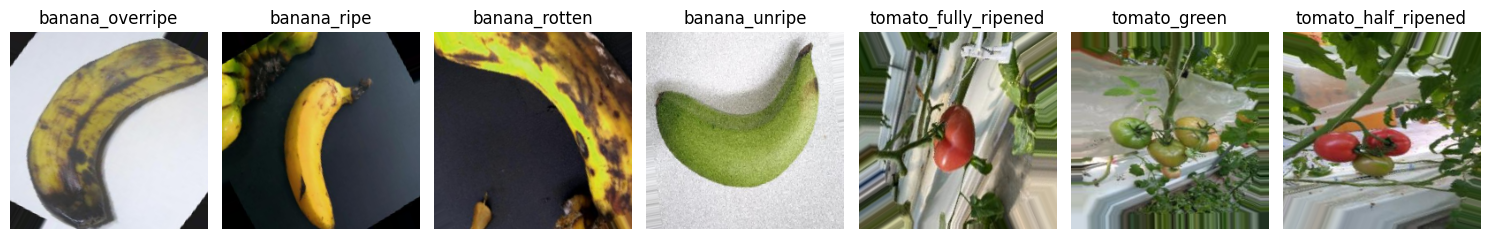

In [11]:
import matplotlib.pyplot as plt
import numpy as np

num_classes = len(train_data.class_indices)
class_names = list(train_data.class_indices.keys())

samples_per_class = {}

while len(samples_per_class) < num_classes:
    images, labels = next(train_data)  
    for img, label in zip(images, labels):
        class_index = np.argmax(label)
        if class_index not in samples_per_class:
            samples_per_class[class_index] = img
        if len(samples_per_class) == num_classes:
            break

plt.figure(figsize=(15, 8))
for class_index, img in samples_per_class.items():
    ax = plt.subplot(1, num_classes, class_index + 1)
    plt.imshow(img)
    plt.title(class_names[class_index])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
print(class_labels)
print(train_data.class_indices)

['banana_overripe', 'banana_ripe', 'banana_rotten', 'banana_unripe', 'tomato_fully_ripened', 'tomato_green', 'tomato_half_ripened']
{'banana_overripe': 0, 'banana_ripe': 1, 'banana_rotten': 2, 'banana_unripe': 3, 'tomato_fully_ripened': 4, 'tomato_green': 5, 'tomato_half_ripened': 6}


In [13]:
def calculate_class_weights_tf(labels):
    """
    Calculates class weights based on the frequency of each class in a TensorFlow tensor.

    Args:
        labels (tf.Tensor): 1D TensorFlow tensor of class labels (integer type).

    Returns:
        dict: A dictionary where keys are class labels (as Python integers) and
              values are their corresponding class weights (as Python floats).
              Returns an empty dict if input is invalid.
    """
    if not isinstance(labels, tf.Tensor):
        print("Error: Input 'labels' must be a TensorFlow tensor.")
        return {}  # Return an empty dictionary for error handling

    if labels.shape.ndims != 1:
        print("Error: Input 'labels' must be a 1D tensor.")
        return {}

    if labels.dtype not in [tf.int32, tf.int64]:
        print("Error: Input 'labels' must be an integer tensor (tf.int32 or tf.int64).")
        return {}

    unique_labels, _ = tf.unique(labels)
    num_samples = tf.cast(tf.shape(labels)[0], tf.float32)
    class_counts = tf.cast(tf.math.bincount(tf.cast(labels, dtype=tf.int32)), tf.float32)
    # Add epsilon for numerical stability
    class_weights_tensor = num_samples / (tf.cast(tf.shape(unique_labels)[0], tf.float32) * class_counts + tf.keras.backend.epsilon())

    # Create a dictionary mapping class labels to their weights
    class_weights_dict = {}
    for i, label in enumerate(unique_labels.numpy()):
        class_weights_dict[label] = class_weights_tensor[i].numpy()

    return class_weights_dict


In [14]:
y_train = train_data.classes
num_classes = train_data.num_classes
print(f"Number of classes: {num_classes}")
input_shape = train_data.image_shape

# Convert labels to TensorFlow tensor
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.int32)


# 3. Calculate class weights
class_weights = calculate_class_weights_tf(y_train_tensor)

print("Class labels:", np.unique(y_train))
print("Calculated class weights:", class_weights)


Number of classes: 7
Class labels: [0 1 2 3 4 5 6]
Calculated class weights: {0: 0.81993085, 1: 0.794308, 2: 0.5757159, 3: 0.8347408, 4: 2.289897, 5: 1.4587005, 6: 2.1540556}


I0000 00:00:1747429650.028984      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747429650.029624      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [16]:
import tensorflow as tf
from tensorflow.keras import layers
import math
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import numpy as np
import os

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.embed_dim = embed_dim #added embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate

    def call(self, inputs, training=False): 
        attn_output = self.att(inputs, inputs, training=training) 
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    def get_config(self):
        config = super(TransformerBlock, self).get_config()
        config.update({
            'embed_dim': self.embed_dim,
            'num_heads': self.num_heads,
            'ff_dim': self.ff_dim,
            'rate': self.rate,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


class VisionTransformer(tf.keras.Model):
    def __init__(self, image_size, patch_size, num_classes, embed_dim, num_heads, ff_dim, num_layers, rate=0.1, channels=3): # Added channels
        super(VisionTransformer, self).__init__()
        self.image_size = image_size 
        self.patch_size = patch_size 
        self.num_patches = (image_size // patch_size) ** 2
        self.patch_dim = (patch_size * patch_size * channels) 
        self.embed_dim = embed_dim
        self.num_classes = num_classes 
        self.channels = channels
        self.num_layers = num_layers 


        # Patch embedding layer
        self.patch_embed = layers.Dense(embed_dim)

        # Positional embedding
        self.pos_embed = self.add_weight(
            shape=(1, self.num_patches, embed_dim),
            initializer="random_normal",
            trainable=True,
        )

        # Transformer blocks
        self.transformer_blocks = [
            TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)
        ]

        # Classification head
        self.mlp_head = tf.keras.Sequential([
            layers.LayerNormalization(epsilon=1e-6),
            layers.Dense(128, activation="relu"),
            layers.Dropout(rate),
            layers.Dense(num_classes, activation="softmax")
        ])



    def build(self, input_shape): 
        super(VisionTransformer, self).build(input_shape)
        if not self.mlp_head.built:
            self.mlp_head.build(input_shape=(None, self.embed_dim)) 

    def extract_patches(self, images, patch_size):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, patch_size, patch_size, 1],
            strides=[1, patch_size, patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_dim])
        return patches

    def call(self, inputs, training=False): 
        if len(inputs.shape) == 3:
            inputs = tf.expand_dims(inputs, axis=1)
        patches = self.extract_patches(inputs, patch_size=self.patch_size)

        # Embed patches
        x = self.patch_embed(patches)

        # Add positional embedding
        x += self.pos_embed

        # Pass through transformer blocks
        for block in self.transformer_blocks:
            x = block(x, training=training) 

        # Global average pooling
        x = tf.reduce_mean(x, axis=1)

        # Classification head
        return self.mlp_head(x)

    def get_config(self):
        config = super(VisionTransformer, self).get_config()
        config.update({
            'image_size': self.image_size,
            'patch_size': self.patch_size,
            'num_classes': self.num_classes,
            'embed_dim': self.embed_dim,
            'num_heads': 8,
            'ff_dim': 256,
            'num_layers': self.num_layers,
            'rate': 0.4,
            'channels': 3,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)


def create_hybrid_model(image_size, num_classes, channels=3):
    """
    Creates a hybrid CNN-ViT model.  The CNN acts as a feature extractor,
    and the ViT processes the extracted features.

    Args:
        image_size: The size of the input image.
        num_classes: The number of classes for classification.
        channels: Number of channels
    Returns:
        A tf.keras.Model instance representing the hybrid model.
    """
    # CNN Feature Extractor
    cnn_model = tf.keras.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(image_size, image_size, channels)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)), 
    ])

    # Determine the shape of the CNN output
    cnn_output_shape = cnn_model.output_shape
    cnn_output_size = cnn_output_shape[1]
    cnn_output_channels = cnn_output_shape[3]

    
    # ViT Parameters
    patch_size = 1  
    embed_dim = 256
    num_heads = 8
    ff_dim = 256
    num_layers = 6
    dropout_rate = 0.4

    # ViT Model
    vit_model = VisionTransformer(
        image_size=cnn_output_size,  
        patch_size=patch_size,
        num_classes=num_classes,
        embed_dim=embed_dim,
        num_heads=num_heads,
        ff_dim=ff_dim,
        num_layers=num_layers,
        rate=dropout_rate,
        channels=cnn_output_channels
    )

    # Hybrid Model
    inputs = tf.keras.Input(shape=(image_size, image_size, channels))
    cnn_features = cnn_model(inputs)
    # Reshape the CNN output to be compatible with ViT's patch embedding
    x = layers.Reshape(target_shape=(cnn_output_size * cnn_output_size, cnn_output_channels))(cnn_features)
    outputs = vit_model(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)




# Define the model parameters 
DROPOUT_RATE = 0.4
CHANNELS = 3 
LEARNING_RATE = 1e-4 
NUM_CLASSES = train_data.num_classes

print(f"Number of Classes: {NUM_CLASSES}")


# Create the Vision Transformer model
Transformer = create_hybrid_model(
    image_size=IMAGE_SIZE,
    num_classes=NUM_CLASSES,
    channels=CHANNELS
)
# Compile the model
optimizer = tf.keras.optimizers.AdamW(learning_rate=LEARNING_RATE) 
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False) 

Transformer.compile(
    optimizer=optimizer,
    loss=loss_fn,
    metrics=['accuracy']
)

# Print a summary of the model
Transformer.build(input_shape=(None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

Transformer.summary()

tf.keras.utils.plot_model(Transformer, to_file='Transformer.png', show_shapes=True, show_layer_names=True)

# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=12,
    restore_best_weights=True,
    verbose=1
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=6,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='/kaggle/working/Transformer.weights.h5',  
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,  
    mode='max',
    verbose=1
)


callbacks = [early_stopping, reduce_lr, checkpoint]

Number of Classes: 7


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_8 (Sequential)            │ (None, 14, 14, 256)         │         388,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 196, 256)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vision_transformer_1                 │ (None, 7)                   │      13,567,239 │
│ (VisionTransformer)                  │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,955,655 (53.24 MB)

 Trainable params: 13,955,655 (53.24 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = Transformer.fit(
    train_data,
    validation_data=val_data,
    epochs=100,
    callbacks=callbacks,
    class_weight=class_weights,
)

output_dir = '/kaggle/working/Transformer.keras'
Transformer.save(output_dir)
print(f"Model saved successfully to: {output_dir}")

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747429685.194416     140 service.cc:148] XLA service 0x79bbd4003060 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747429685.195207     140 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1747429685.195216     140 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1747429687.594261     140 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1747429705.591133     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of th

223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.2202 - loss: 1.8151
Epoch 1: val_accuracy improved from -inf to 0.30765, saving model to /kaggle/working/Transformer.weights.h5
223/223 ━━━━━━━━━━━━━━━━━━━━ 208s 711ms/step - accuracy: 0.2205 - loss: 1.8139 - val_accuracy: 0.3076 - val_loss: 1.3556 - learning_rate: 1.0000e-04
Epoch 2/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.5043 - loss: 1.1449
Epoch 2: val_accuracy improved from 0.30765 to 0.72272, saving model to /kaggle/working/Transformer.weights.h5
223/223 ━━━━━━━━━━━━━━━━━━━━ 136s 598ms/step - accuracy: 0.5046 - loss: 1.1443 - val_accuracy: 0.7227 - val_loss: 0.7352 - learning_rate: 1.0000e-04
Epoch 3/100
223/223 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.7101 - loss: 0.7740
Epoch 3: val_accuracy improved from 0.72272 to 0.75028, saving model to /kaggle/working/Transformer.weights.h5
223/223 ━━━━━━━━━━━━━━━━━━━━ 137s 600ms/step - accuracy: 0.7101 - loss: 0.7741 - val_accuracy: 0.7503 - val_loss: 0.6

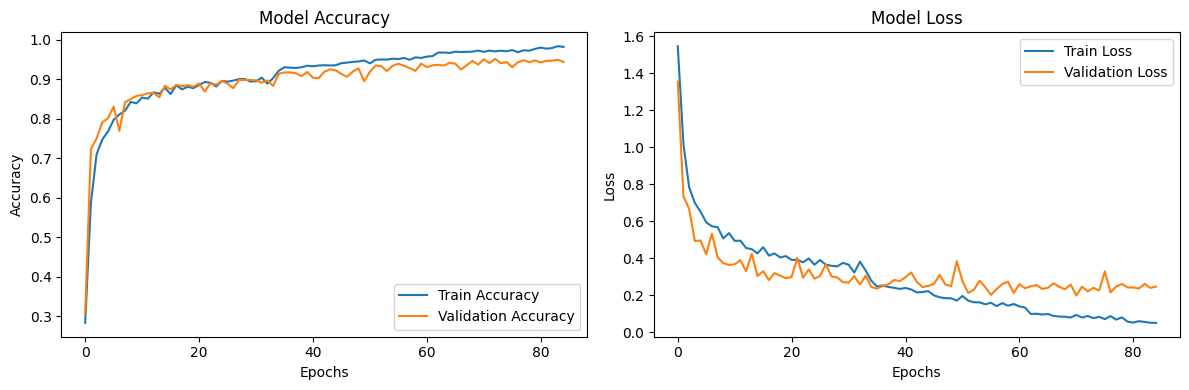

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

val_preds = np.argmax(Transformer.predict(val_data), axis=1)
val_labels = val_data.classes
print(classification_report(val_labels, val_preds, target_names=list(val_data.class_indices.keys())))

56/56 ━━━━━━━━━━━━━━━━━━━━ 46s 789ms/step
                      precision    recall  f1-score   support

     banana_overripe       0.96      0.97      0.96       310
         banana_ripe       0.95      0.98      0.97       320
       banana_rotten       0.98      0.96      0.97       441
       banana_unripe       0.99      0.99      0.99       304
tomato_fully_ripened       0.90      0.88      0.89       111
        tomato_green       0.91      0.95      0.93       174
 tomato_half_ripened       0.86      0.81      0.83       118

            accuracy                           0.95      1778
           macro avg       0.94      0.93      0.94      1778
        weighted avg       0.95      0.95      0.95      1778



Text(50.58159722222221, 0.5, 'True Labels')

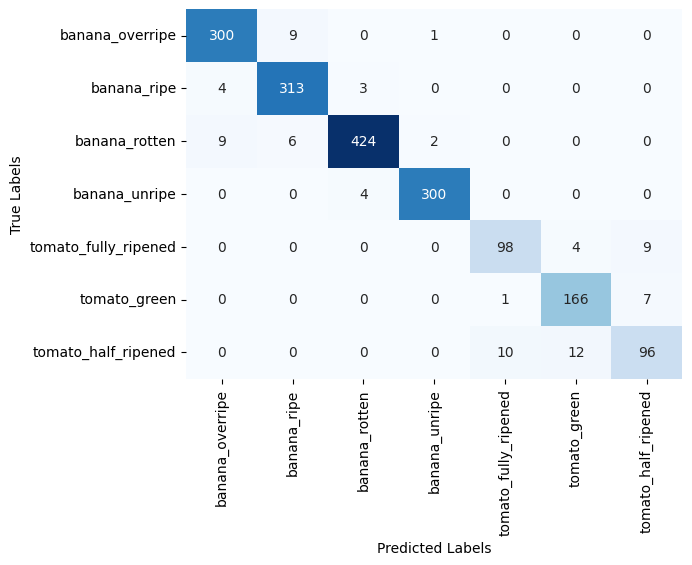

In [20]:
cm = confusion_matrix(val_labels, val_preds)
class_names = val_data.class_indices.keys()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')   

In [22]:
import pandas as pd
import numpy as np
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Define the class label mapping (for converting numerical predictions to the required indices)
class_mapping = {
    'banana_overripe': 0,
    'banana_ripe': 1,
    'banana_rotten': 2,
    'banana_unripe': 3,
    'tomato_fully_ripened': 4,
    'tomato_green': 5,
    'tomato_half_ripened': 6
}

reverse_class_mapping = {v: k for k, v in class_mapping.items()}


test_data_gen = ImageDataGenerator(    
    rescale=1./255,
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest')


test_image_files = sorted([f for f in os.listdir('/kaggle/input/fine-grained-fruit-quality-assessment/test/testNew') if os.path.isfile(os.path.join('/kaggle/input/fine-grained-fruit-quality-assessment/test/testNew', f))])


test_data = test_data_gen.flow_from_dataframe(
    pd.DataFrame({'filename': test_image_files}),
    directory='/kaggle/input/fine-grained-fruit-quality-assessment/test/testNew',
    x_col='filename',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode=None,  # No labels for test data
    shuffle=False
)

test_preds = Transformer.predict(test_data)

predicted_classes = np.argmax(test_preds, axis=1)


image_ids = test_image_files


submission_df = pd.DataFrame({'ImageID': image_ids, 'Class': predicted_classes})


submission_df.to_csv('/kaggle/working/mobilenet_functional_model.csv', index=False)

print("Submission file 'submission.csv' has been created successfully!")

Found 2484 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 50s 617ms/step
Submission file 'submission.csv' has been created successfully!


In [23]:
submission_df.to_csv('/kaggle/working/Transformer.csv', index=False)

In [ ]:
Transformer.save('/kaggle/working/Transformer_model.keras')


In [ ]:
Transformer.save_weights('/kaggle/working/Transformer_model.weights.h5')